# Homework Assignment 2

### **Due:** Wednesday, Oct 19, 11:59pm
### Total: 100 points

In this assignment, you will import data to Python from different online sources; namely, a webpage and the Wikipedia API. You need to complete the data import and transformation by using the web scraping tools we have covered in class and some string methods as well. (Directions will be given before the string operations.)

As you will see in your final results, software that scrapes online sources and transforms the data to a structured format needs to be very intricate. Otherwise, it is very easy to encounter garbage results which are caused by slight formatting differences or specific details in the web page you are using. Discussion of this point will be repeated at the end of this assignment.

In [1]:
# This cell imports all the libraries you need for this assignment
import requests
import pandas as pd
import matplotlib.pyplot as plt
from scrapy import Selector
from collections import Counter
from bs4 import BeautifulSoup
import numpy as np

### 1) Reading a table from a web page (20 points)

Start with reading the table from the webpage with the URL given below. It is the U.S. university rankings for last year from the Center for World University Rankings (CWUR). You will only use the column that has the university names.

In the following questions, you will use these names and the Wikipedia API to extract the states that the universities are in.

In [2]:
# The URL of the web page
url = 'https://cwur.org/2021-22/country/usa.php'

# The header that will send your request not as a Python user but as another web page. (This is necessary to have access.)
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

# Create the request and get the response using the URL and the header above 
# Hint: The header should go the headers input of the .get() method.

r = requests.get(url, headers = header)


# Use the text attribute of the response as the input to the read_html function of Pandas to obtain the table(s) on the webpage.
df = pd.read_html(r.text)

# You should see the main table on the webpage as a dataframe in your output in the previous line.
# Pick the column that has the university names and convert it to a list.
institutions = df[0]['Institution']

# Pick the first 150 names.
institutions.head(150)

# Lastly, save the list that has the 150 names to another variable. Use .copy() method. While you will use the original
# list to scrape data, the copy will be used at the very end.
names = list(institutions.head(150))
copy = names.copy()

### 2) Text Cleaning (25 points)

Before you use the university names to extract the states they're in from Wikipedia, you need some text cleaning to make the textual data less messy. Make the names more uniform to be able to use them with the same pattern and also create two user-defined functions as single-line tools you can use in the next question.

**a)** **(6 points)** First, create a for loop that iterates through each name in the list **using an index.** You need this loop to trim the names that have a **"-", "," or "at"** in them. When you use Wikipedia API with the names, the part that comes after these strings has the potential to create many errors. Therefore, all the words that come after "-", "," or "at" should be trimmed, along with the "-", "," or "at" itself. (e.g. University of Illinois at Urbana Champaign should be University of Illinois.)

To implement this, you need two string methods: **.split()** and **.rstrip()**. The .split() method splits a string into a list of strings using its input as the separator. You need to use the given strings above as input and then pick the first element in the output list to trim each university name. After that, you need to use .rstrip() method to get rid of the space character at the end of your remaining string.

**Hint:** For the .split() method, note that if the string does not include the input separator, it will simply stay the same, so you can repeat the same method three times in the for loop without any issues.

In [3]:
# Create a for loop that iterates through a range of numbers: from 0 to the length of the college names list
for i in range(len(copy)):

    # For each name in the list, using the iterator as the index, delete the "-" and the words that come after it for each name.
    # Save the trimmed name to the same index in the list.
    new = copy[i].split('-')
    copy[i] = new[0].rstrip(' ')
    # Repeat for ","
    new = copy[i].split(',')
    copy[i] = new[0].rstrip(' ')
    # Repeat for "at"
    new = copy[i].split(' at')
    copy[i] = new[0].rstrip(' ')
    # Repeat for "–"
    new = copy[i].split('–')
    copy[i] = new[0].rstrip(' ')

**b)** **(6 points)** Second, create a user-defined function called **NameFormatter** that takes one string input and replaces all the space characters with an underscore (_) and the ampersand symbol ('&') with '%26'. You need the names in this changed format to be able add them to the URL requests for the Wikipedia API. In this function, you need to use the **.replace()** method.

**Hint:** Again, if the string does not include the first input to the .replace() method, it will simply stay the same, so it is okay to repeat the method in consecutive lines.

In [4]:
# Create the user-defined function. Using the input string two times with the .replace() method, create and return the output
def NameFormattr(line):
    line = line.replace(' ', '_')
    line = line.replace('&', '%26')
    return line

**c)** **(13 points)** Lastly, create another user-defined function called **StateName** that takes one string input and returns its last word or words depending on the name of the US state in the string. You will need this function to return the name of the state the university is in after extracting the first sentence from the university's Wikipedia page using the API. **(Note that on the Wikipedia page for most universities, the first sentence ends with "in city, state" format.)**

In [5]:
# Create the function, using only one input - the first sentence from Wikipedia
def StateName(sentence):
# Split the sentence into a list of words using .split()
    x = sentence.split(" ")
# If the second last element in the list is "New", "North" or "South", pick and return the last two words in the list.
    if  x[-2] == 'New':
        return '{} {}' .format(x[-2], x[-1])
    if  x[-2] == 'North':
        return '{} {}' .format(x[-2], x[-1])
    if  x[-2] == 'South':
        return '{} {}' .format(x[-2], x[-1])
# If the last element in the list is "City", return "New York".
    if x[-1] == 'City':
        return 'New York'
# If the last element in the list is "D.C.", return "Washington D.C."
    if x[-1] == 'D.C.':
        return 'Washington D.C,'
# Else, return the last word.
    else: 
        return x[-1]

### 3) Wikipedia API (25 points)

You have all the tools to extract the states using the university names and the functions you created. Iterate through the updated name list to create each university's URL request for the Wikipedia API and return the first sentence on the Wikipedia page of each university. Using the first sentence, return the state each university is in. You will need to extract some additional information as well.

**Hint: The JSON data from the Wikipedia API is more complex than what we covered in class. After you capture the JSON data for each university, you need to go through four layers of nested dictonaries. My suggestion is to keep printing the keys and values to see what your next step should be. (Feel free to create new cells or use Spyder.)**

In [6]:
## Create two empty lists. Call them states and related_names
states = []
related_names = []

# Start a for loop that iterates through the university names that are updated in 2a.
for university in copy:
    # Use NameFormatter to change the name to a wikipedia extension
    ext = NameFormattr(university)
    # Create the URL request for Wikipedia API
    # The name extension should come after 'https://en.wikipedia.org/w/api.php?action=query&prop=extracts&format=json&exintro=&titles='
    website = 'https://en.wikipedia.org/w/api.php?action=query&prop=extracts&format=json&exintro=&titles='
    url = "{}{}".format(website, ext)
    # Create a request using the url and obtain a response from the API
    r = requests.get(url)
    # Save the json data of the response to a variable
    data = r.json()
    # The variable you created above is a nested dictionary. You need to use the correct keys to reach the Wikipedia text.
    nested = data['query']['pages']
    pageid = list(nested.values())[0]['extract']
    # From the extracted text, pick the first sentence by using .split() with "." as input and indexing.
    # PS: This is not a very robust method but it is ok for this assignment.
    line = pageid.split('. ')[0]
    # From the extracted text, pick the bold text elements using a scrapy Selector object and xpath notation.
    sel = Selector(text = line)
    bolded = sel.xpath('/html/body/p//b/text()').extract()
    bold = ', '.join(bolded)
    # Extract the state name from the first sentence using the StateName function.
    state_name = StateName(line)
    # Append the state name to the states list.
    states.append(state_name)
    # Append the bold text elements to the related_names list
    related_names.append(bold)

### 4) Creating DataFrames (20 points)

**a)** **(6 points)** Using the lists with the **original** university names, states and bold elements, create a pandas DataFrame. Name the columns "Name," "State," and "Related Names," respectively. Display the first 15 rows of the DataFrame.

In [7]:
d = {'Name':names, 'State':states, 'Related Names':related_names}

universities = pd.DataFrame(d)

universities.head(15)

,Name,State,Related Names
0,Harvard University,Massachusetts,Harvard University
1,Massachusetts Institute of Technology,Massachusetts,"Massachusetts Institute of Technology, MIT"
2,Stanford University,California,"Stanford University, Leland Stanford Junior Un..."
3,Princeton University,New Jersey,Princeton University
4,Columbia University,New York,"Columbia University, Columbia, Columbia Univer..."
5,University of Chicago,Illinois,"The University of Chicago, UChicago, Chicago, ..."
6,University of Pennsylvania,Pennsylvania,"University of Pennsylvania, Penn, UPenn"
7,Yale University,Connecticut,Yale University
8,California Institute of Technology,California,"California Institute of Technology , Caltech"
9,"University of California, Berkeley",U.S,"University of California, UC"


**b)** **(14 points)** Use the states list and the **Counter** object (imported at the very beginning) to tally the number of occurences for each state. Save the tally as a dictionary with the state name and the number of occurrences as key-value pairs.

You just need to give the list as the input for the Counter object and convert its output to a dictionary afterwards. Use the dictionary to convert the tally data into another DataFrame. The first column should be "State" and the second column should be "Count." Use the DataFrame to create a bar plot.

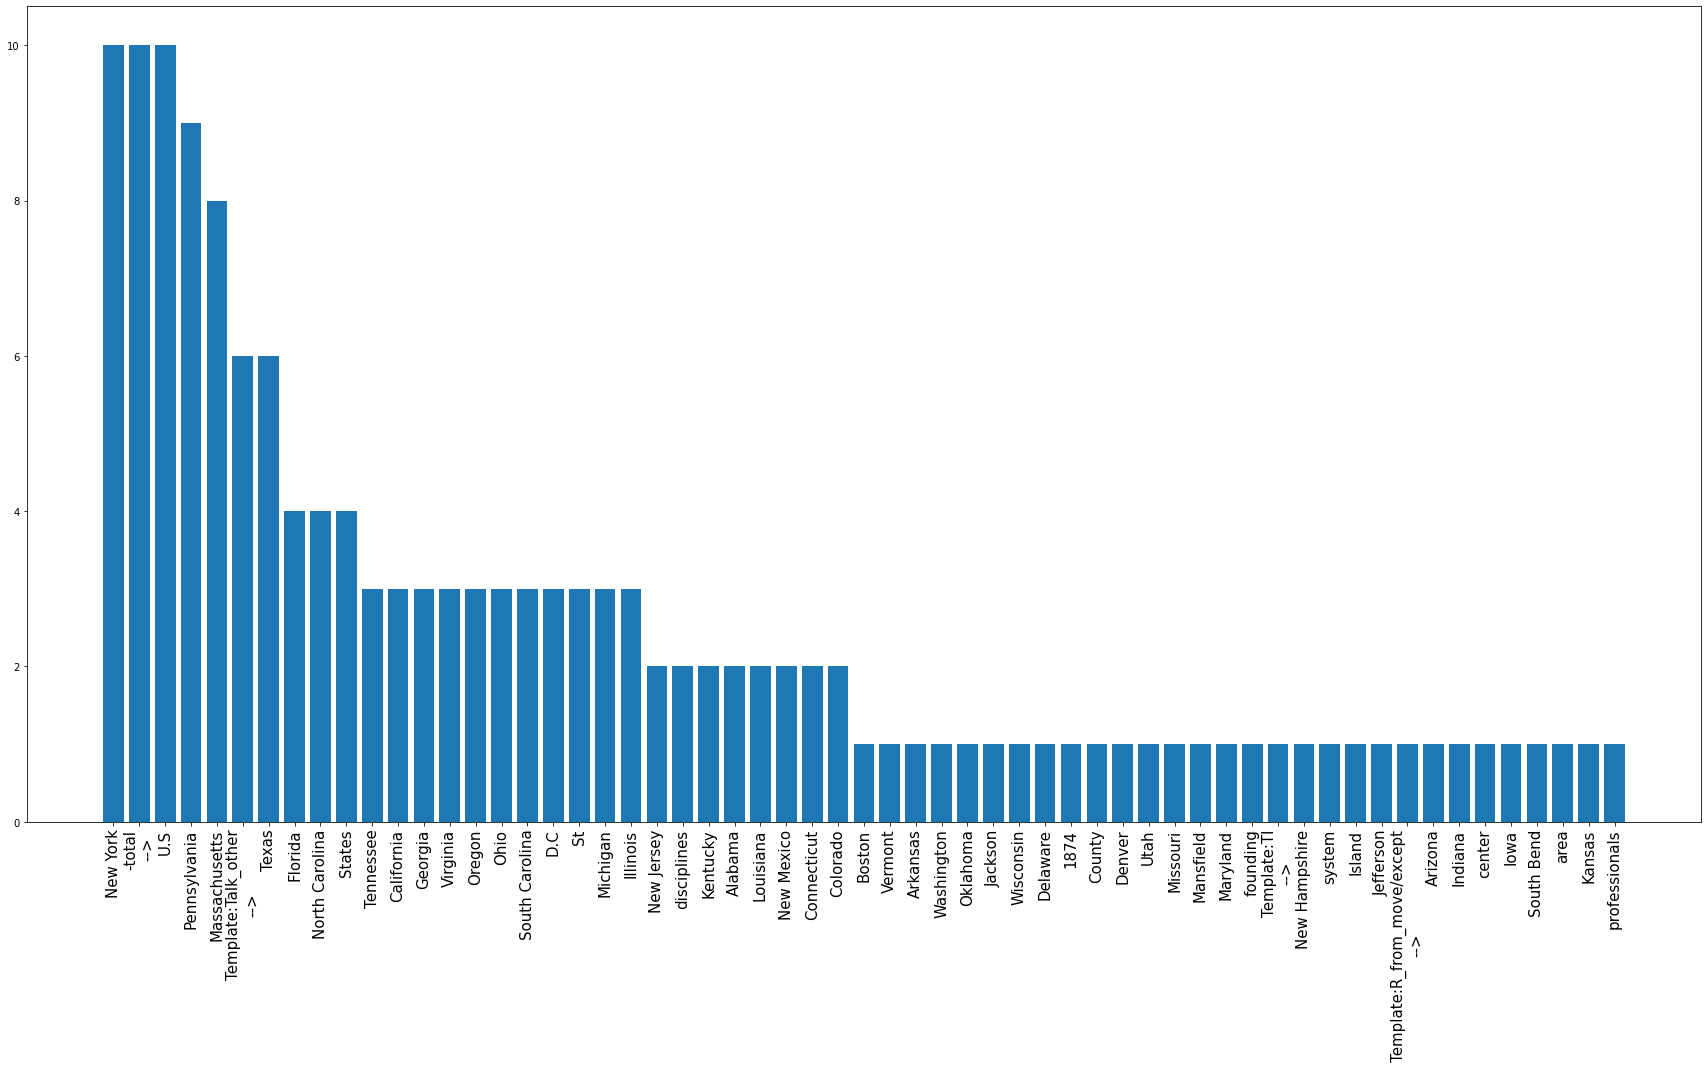

In [8]:
# Convert the states list into a dictionary
c = Counter(states)
b = dict(c)
# Convert the dictionary into a dataframe
df = pd. DataFrame.from_dict(b, orient = 'index')
df['Count'] = df[0]

df.drop(columns = 0, inplace = True)

# Fill the missing line below that sorts the Count column in descending order (check .sort_values()) and then creates a bar plot.
plt.figure(figsize=(30,15))
y_pos = np.arange(len(df.Count))
df.sort_values(by = 'Count', ascending = False, inplace = True)
plt.bar(y_pos, height = df.Count)
plt.xticks(y_pos, df.index.values, fontsize=15, rotation=90)
plt.show()


### 5) Final Question (10 points)

As you have learned, while most universities returned a valid state, some returned garbage results, such as 0 or U. This is normal when it comes to unstructured textual data. Developers usually spend months as a team to perfect their text software. In a few sentences, propose one method (which does not have to be very complex) to reduce the amount of garbage results. You do not need to demonstrate it with additional code.

**Some particular outputs I noticed were the difficulties of dealing with universities which had multiple campuses (such as the UC system schools) and how since we chose to ignore the mention of the different campuses, the results of these schools became identical. The differing format of the general "University of California" Wikipedia page meant that the states column contains values like "U.S" versus the correct answer (California). As a result, I think we should go about not dropping the campus names for university systems like we did initially. Ideally, we could potentially use something like .join to be able to utilize the campus name in the url of the wiki search in order to get the more specified information page. This would then remedy the odd state name entries in the states column and the generic and redundant related nicknames like "University of California, UC" for every single UC school.**